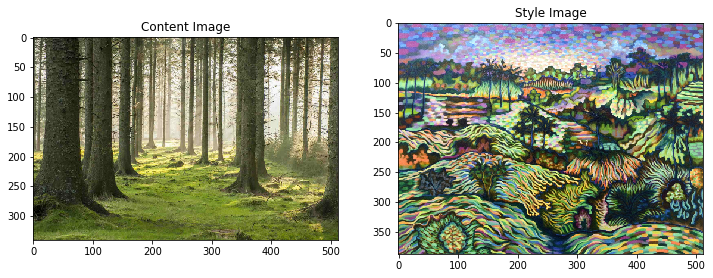

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False

from util import imshow, load_img, save_img, upscale, apply_lum, match_lum, match_color_histogram
from transfer import transfer_style

# load input images
# https://images1.novica.net/pictures/10/p348189_2a.jpg, https://www.novica.com/p/impressionist-painting-in-delod-pangkung/348189/
style_path = tf.keras.utils.get_file('impressionist-bali.jpg','file:///home/jupyter/pictures/impressionist-bali.jpg')

# https://www.positive.news/wp-content/uploads/2019/03/feat-1800x0-c-center.jpg
content_path = tf.keras.utils.get_file('forest.jpg','file:///home/jupyter/pictures/forest.jpg')

# given the size of the receptive fields, the sweet spot of the network is around 500x500 pixels
# we will then transfer style on low res images, then upscale the result and use it as gradient initializer to do the high res style transfer

content_img = load_img(content_path, max_dim=512)
style_img = load_img(style_path, max_dim=512)

content_img_highres = load_img(content_path, max_dim=2048)
style_img_highres = load_img(style_path, max_dim=2048)

plt.subplot(1, 2, 1)
imshow(content_img, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_img, 'Style Image')

plt.show()

W0717 07:40:39.944900 139698720864000 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


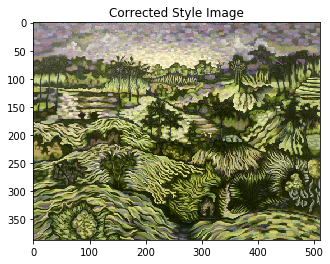

In [2]:
# Instead of matching luminosity, we match the color histograms
style_img = match_color_histogram(content_img, style_img)
style_img_highres = match_color_histogram(content_img_highres, style_img_highres)

imshow(style_img, 'Corrected Style Image')

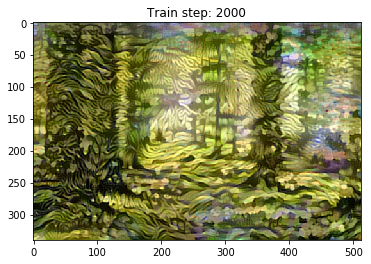

Total time: 69.2


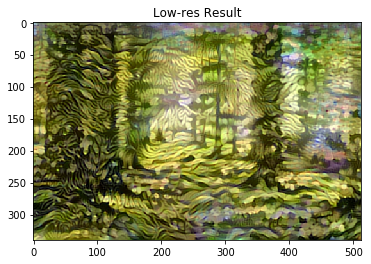

In [3]:
# Run the style transfer for low resolution
style_weights = [ 1e3/n**2 for n in [64, 128, 256, 512, 512] ]
style_weights = [w/sum(style_weights) for w in style_weights]

lowres_transferred = transfer_style(content_img, style_img, alpha=1e1, beta=1e-2, total_variation_weight=1e8, style_weights = [1.0, 1.0, 1.0, 1.0, 1.0], epochs=20)
imshow(lowres_transferred, 'Low-res Result')
save_img(lowres_transferred[0], 'output-lowres.png')

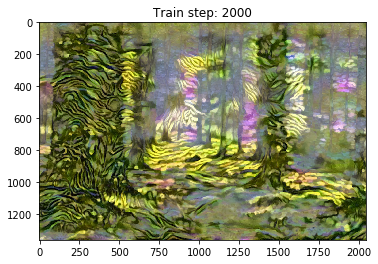

Total time: 866.8


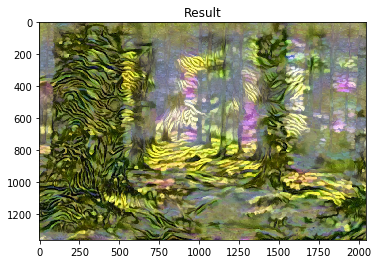

In [4]:
# Upscale the low resolution transferred image
upscaled_transfer = upscale(lowres_transferred[0], content_img_highres.shape[1:3])

# Run the style transfer for high resolution, using the upscaled image for gradient initialization
transferred = transfer_style(content_img_highres, style_img_highres, initial_gradients=upscaled_transfer, alpha=1e1, beta=1e-2, total_variation_weight=1e8, style_weights = [1.0, 1.0, 1.0, 1.0, 1.0], epochs=20)
imshow(transferred, 'Result')
save_img(transferred[0], 'output-highres.png')

W0717 07:56:26.603735 139698720864000 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0717 07:56:26.709160 139698720864000 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


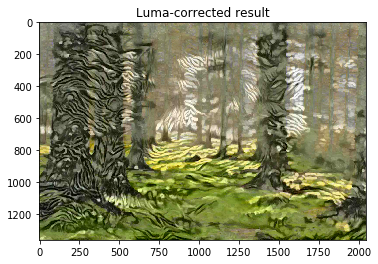

In [5]:
# Apply the original image luma
luma_transferred = apply_lum(content_img_highres, transferred)
imshow(luma_transferred, 'Luma-corrected result')
save_img(luma_transferred[0], 'output-highres-luma.png')